In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Load data

In [2]:
images_folder = '../../images/' 
cmap = 'Set3'

In [3]:
worklogs_calc = pd.read_pickle('../data/worklogs_calc.pkl')
date_cols = ['date', 'issue_min_date', 'issue_max_date']
for col in date_cols:
    worklogs_calc[col] = pd.to_datetime(worklogs_calc[col])
    
users_and_metrics = pd.read_pickle('../data/users_and_metrics.pkl')
date_cols = ['min_date', 'max_date']
for key in users_and_metrics.keys():
    for col in date_cols:
        users_and_metrics[key][col] = pd.to_datetime(users_and_metrics[key][col])

In [4]:
interval = ['20190101', '20221231']
# filter dates
worklogs_calc = worklogs_calc[(worklogs_calc['date'] >= interval[0]) &
                              (worklogs_calc['date'] <= interval[1])]
# set issues status
worklogs_calc['issue_is_closed'] = worklogs_calc['issue_max_date'] <= interval[1]

In [5]:
users_calc = users_and_metrics['2019-2022']
users_calc = users_calc.iloc[:, :-20]
metrics = users_calc.iloc[:, -15:]

# Descriptive statistics

In [6]:
describe = metrics.describe()
describe.loc['skew'] = metrics.skew()
describe.loc['kurt'] = metrics.kurtosis()
describe.T

,count,mean,std,min,25%,50%,75%,max,skew,kurt
velocity,45.0,0.900503,0.441887,0.290909,0.589487,0.851232,1.166077,2.529803,1.156213,2.690558
concentration,45.0,0.076834,0.033838,0.022203,0.050886,0.068796,0.096398,0.177435,0.924775,1.073080
engagement,45.0,0.760491,0.159120,0.273243,0.681319,0.831812,0.866626,0.933373,-1.602352,1.998039
independence,45.0,0.958822,0.021745,0.909454,0.946037,0.963978,0.975156,0.993733,-0.581267,-0.384199
learning,45.0,0.038509,0.076133,0.000000,0.001009,0.012598,0.031355,0.380124,3.241468,11.172281
versatility,45.0,0.937614,0.024478,0.871292,0.926073,0.947260,0.954485,0.965460,-1.359740,1.182477
heterogeneity,45.0,0.847249,0.056375,0.658236,0.842315,0.865078,0.880903,0.909253,-1.874933,3.423599
complexity,45.0,0.031001,0.017346,0.000000,0.016589,0.031549,0.042213,0.072768,0.163747,-0.413406
collaboration,45.0,0.031292,0.018546,0.000000,0.016074,0.025608,0.044455,0.069952,0.403056,-0.881395
sociability,45.0,0.350870,0.187202,0.000000,0.239130,0.340000,0.500000,0.700000,-0.124272,-0.850323


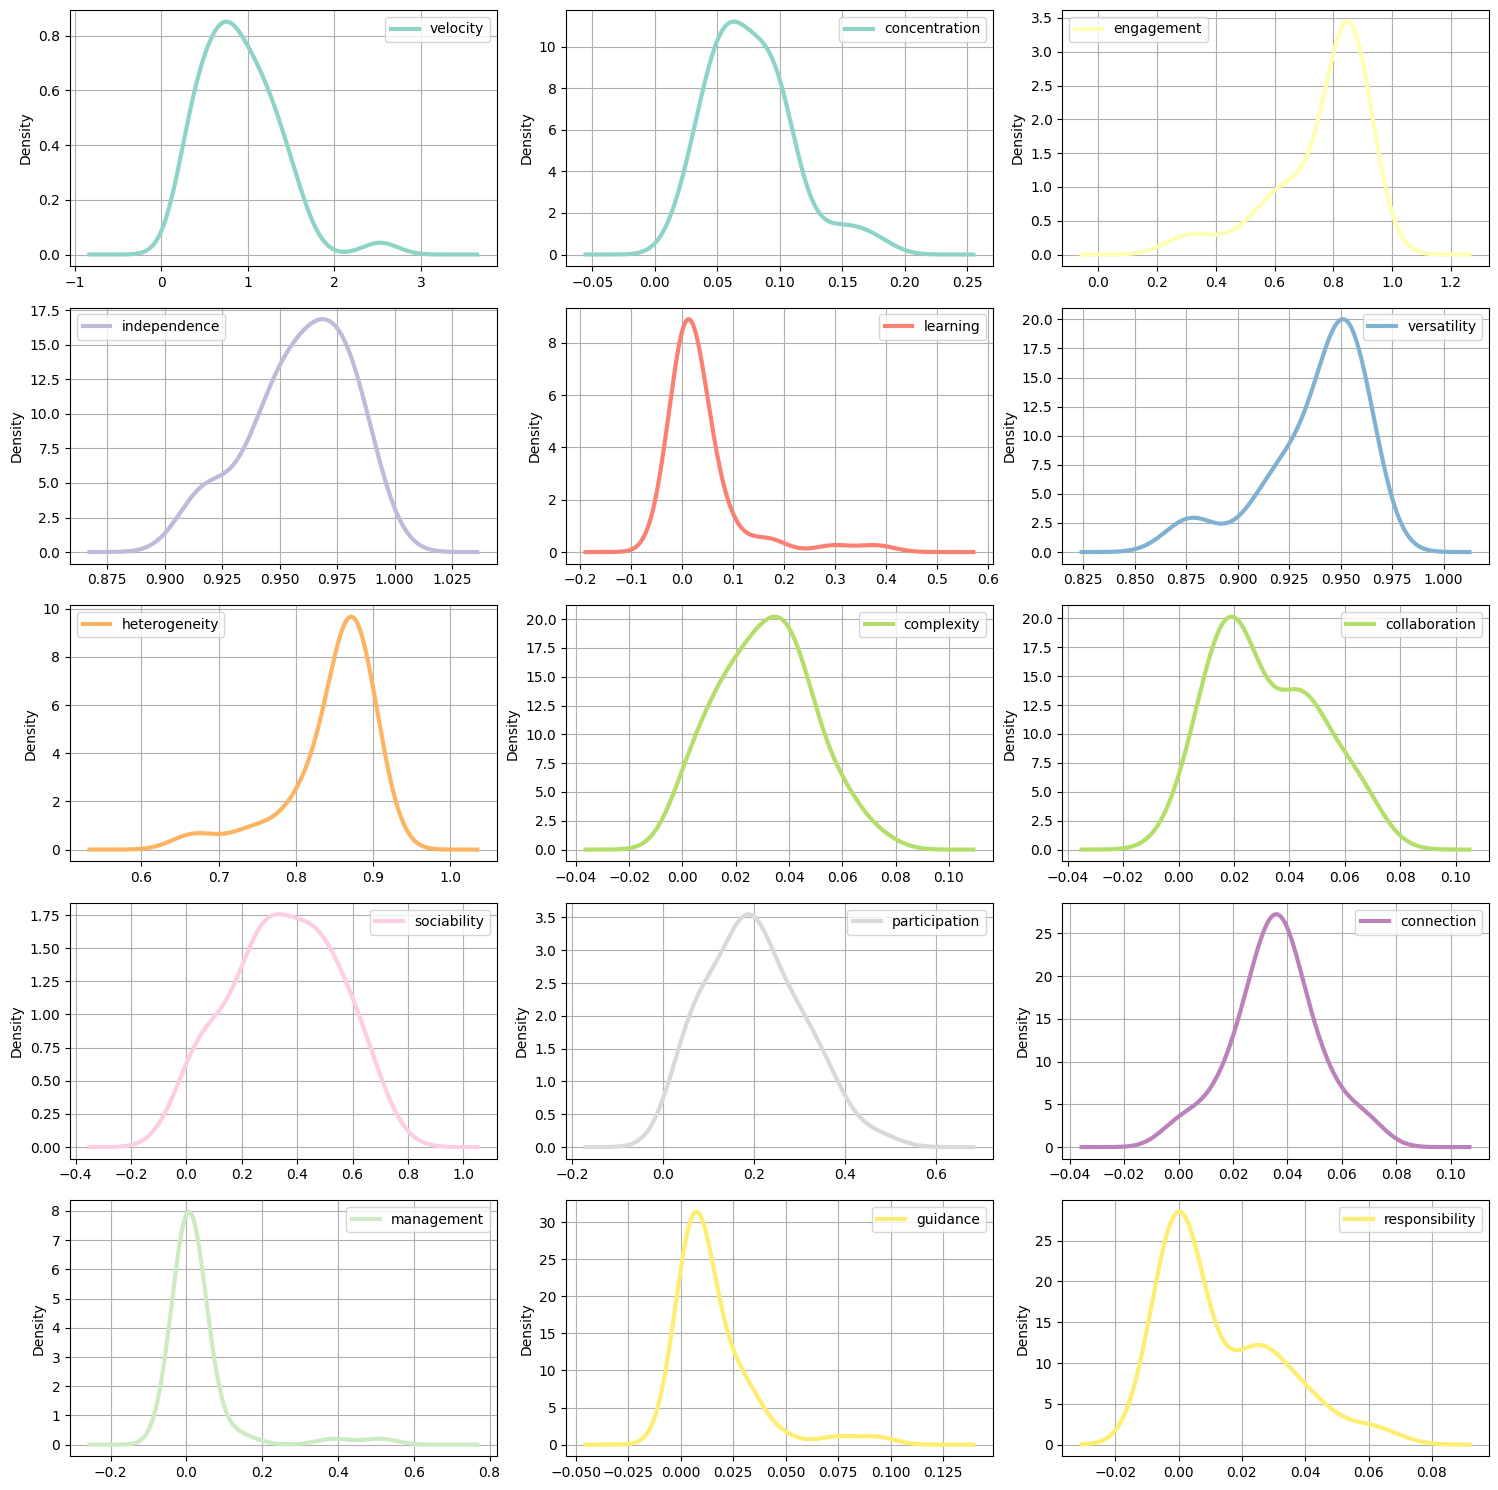

In [7]:
metrics.plot.kde(figsize = (15, 15), layout = (5, 3), subplots=True, cmap=cmap, sharey=False, sharex=False, grid=True, linewidth=3);
plt.tight_layout()
plt.savefig(images_folder + 'metrics_distribution')

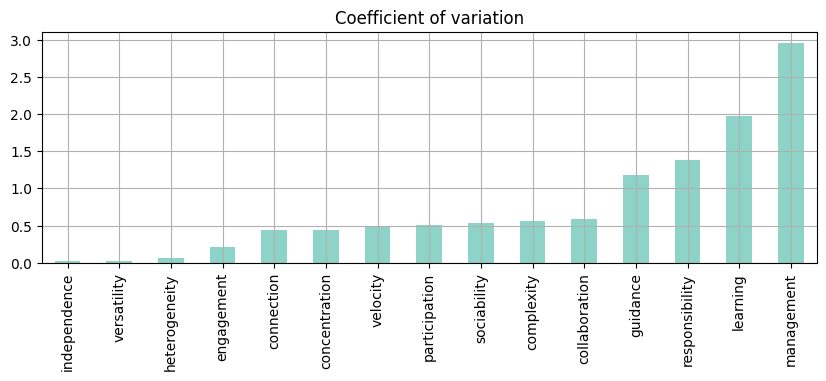

In [8]:
(describe.loc['std'] / describe.loc['mean']).sort_values().plot.bar(
    figsize=(10, 3), grid=True, title='Coefficient of variation', cmap=cmap);

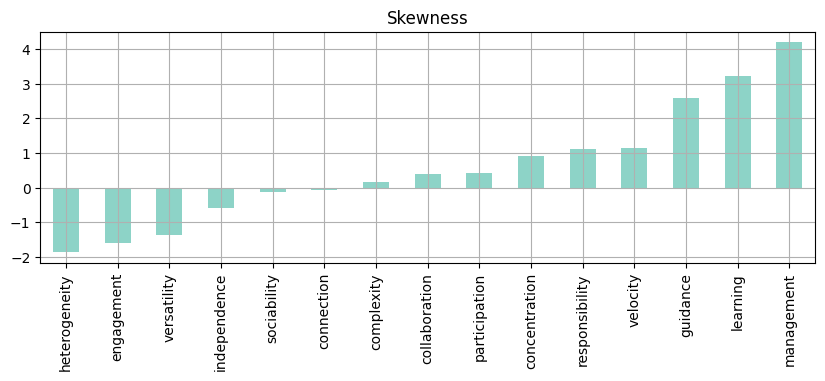

In [9]:
describe.loc['skew'].sort_values().plot.bar(
    figsize=(10, 3), grid=True, title='Skewness', cmap=cmap);

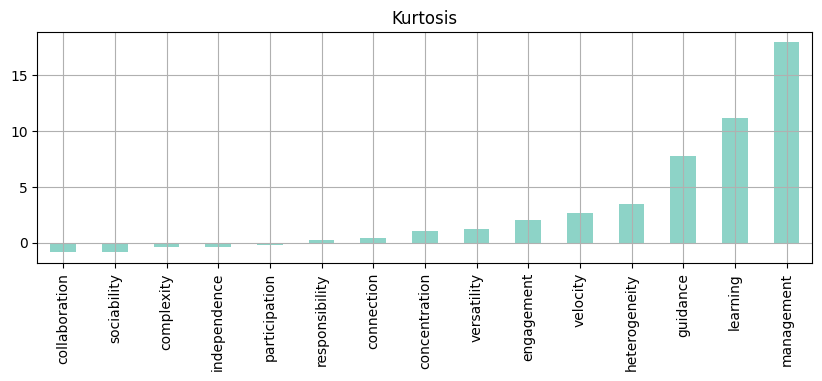

In [10]:
describe.loc['kurt'].sort_values().plot.bar(
    figsize=(10, 3), grid=True, title='Kurtosis', cmap=cmap);

# Top Bottom

In [11]:
keys=['top_user', 'top_value', 'bottom_user', 'bottom_value']
top_bottom = [metrics.idxmax(), metrics.max(), metrics.idxmin(), metrics.min()]
top_bottom = pd.concat(top_bottom, axis=1, keys=keys)
top_bottom

,top_user,top_value,bottom_user,bottom_value
velocity,stella,2.529803,alejandra,0.290909
concentration,leticia,0.177435,marina,0.022203
engagement,paz,0.933373,alba,0.273243
independence,carmen,0.993733,raquel,0.909454
learning,alicia,0.380124,carmen,0.000000
versatility,francisca,0.965460,judith,0.871292
heterogeneity,paz,0.909253,marina,0.658236
complexity,alejandra,0.072768,judith,0.000000
collaboration,maira,0.069952,alejandra,0.000000
sociability,angela,0.700000,alejandra,0.000000


#### Velocity

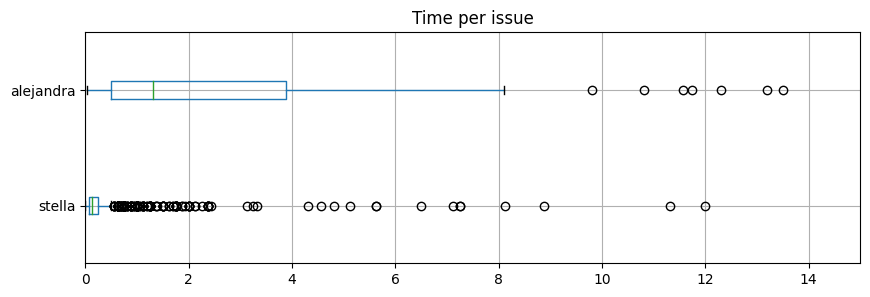

In [12]:
data = pd.pivot_table(worklogs_calc[worklogs_calc['issue_is_closed'] == True],
                      index='issue_leader',
                      columns='issue',
                      values='issue_#hours',
                      aggfunc=np.mean)
data = data / 8

users = top_bottom.loc['velocity', ['top_user', 'bottom_user']].values
ax = data.loc[users].T.dropna(how='all').boxplot(figsize=(10, 3), grid=True, vert=False)
plt.title('Time per issue')
ax.set_xlim([0, 15]); 
plt.savefig(images_folder + 'metrics_example_velocity')

#### Concentration

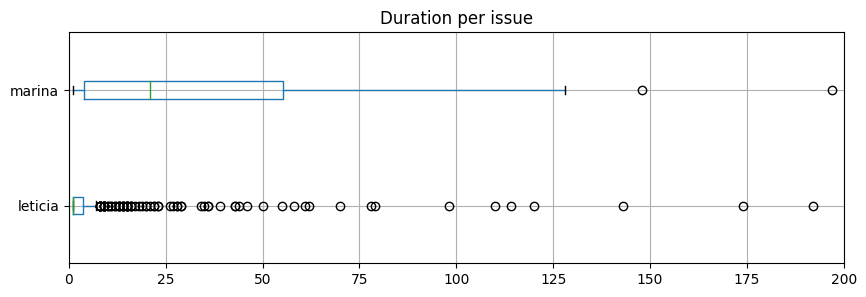

In [13]:
data = pd.pivot_table(worklogs_calc[worklogs_calc['issue_is_closed'] == True],
                      index='issue_leader',
                      columns='issue',
                      values='issue_duration',
                      aggfunc=np.mean)

users = top_bottom.loc['concentration', ['top_user', 'bottom_user']].values
ax = data.loc[users].T.dropna(how='all').boxplot(figsize=(10, 3), grid=True, vert=False)
plt.title('Duration per issue')
ax.set_xlim([0, 200]); 
plt.savefig(images_folder + 'metrics_example_concentration')

#### Engagement

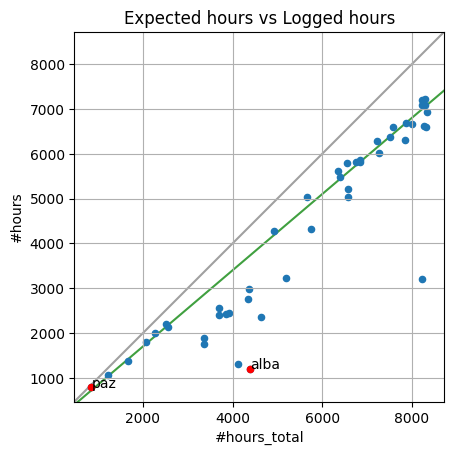

In [14]:
data = users_calc[['#hours_total', '#hours']]
ax = data.plot.scatter(x='#hours_total', y='#hours', grid=True, title='Expected hours vs Logged hours');
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'grey', alpha=0.75, zorder=0)
ax.plot(lims, [x * 0.85 for x in lims], 'g', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
users = top_bottom.loc['engagement', ['top_user', 'bottom_user']].values
ax.text(data.loc[users[0], '#hours_total'], data.loc[users[0], '#hours'], users[0])
ax.text(data.loc[users[1], '#hours_total'], data.loc[users[1], '#hours'], users[1])
data.loc[users].plot.scatter(x='#hours_total', y='#hours', grid=True, ax=ax, color='r');
plt.savefig(images_folder + 'metrics_example_engagement')

#### independence

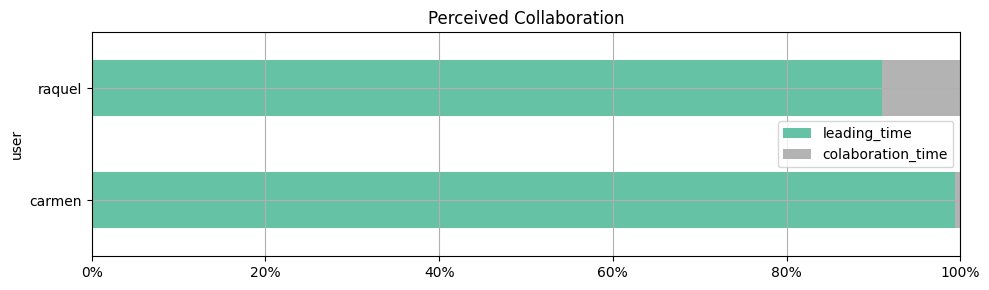

In [15]:
data = users_calc[['leading_time', 'leading_volume']]
data['colaboration_time'] = data['leading_volume'] - data['leading_time']
data = data[['leading_time', 'colaboration_time']]
data = (data.T / data.sum(axis=1)).T
users = top_bottom.loc['independence', ['top_user', 'bottom_user']].values
ax = data.loc[users].plot.barh(stacked=True, figsize=(10, 3), cmap='Set2', grid=True, title='Perceived Collaboration');
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_xlim([0, 1])
plt.tight_layout()
plt.savefig(images_folder + 'metrics_example_independence')

#### learning

In [16]:
users_calc['learning_time'].sum() / users_calc['#hours'].sum()

0.027391045528855733

In [17]:
pd.Series(list(set(worklogs_calc[worklogs_calc['issue_is_learning']]['issue_summary'].values))).sample(5).values

array(['.net framework learning documentation ',
       'research a new way to pack wxkernel for angular 9+',
       'research-ci/cd improvements', 'it migration learning session',
       'initial study, configuration and questions'], dtype=object)

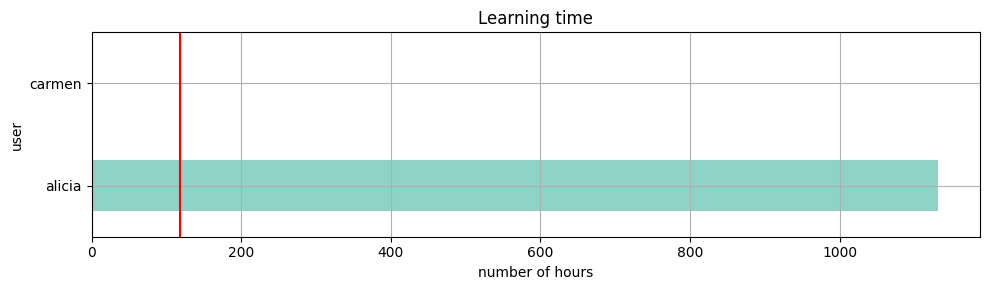

In [18]:
users = top_bottom.loc['learning', ['top_user', 'bottom_user']].values
ax = users_calc['learning_time'].loc[users].plot.barh(figsize=(10, 3), cmap=cmap, grid=True, title='Learning time');
ax.axvline(users_calc['learning_time'].sum() / users_calc.shape[0], color='red')
ax.set_xlabel('number of hours')
plt.tight_layout()
plt.savefig(images_folder + 'metrics_example_learning')

#### versatility

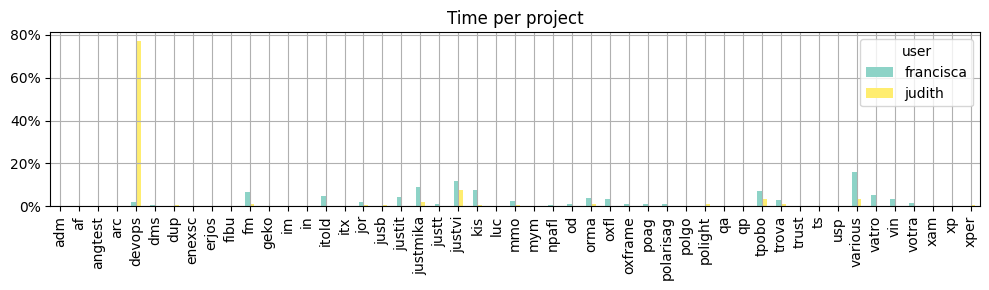

In [19]:
users = top_bottom.loc['versatility', ['top_user', 'bottom_user']].values
project_cols = [x for x in users_calc.columns if x[:8] == 'project_' and x[-5:] == '_time']
data = users_calc.loc[users, project_cols].T
data = data / data.sum()
data = data.rename({x: x.replace('project_', '').replace('_time', '') for x in data.index})
data = data.dropna(how='all')
ax = data.plot.bar(figsize=(10, 3), grid=True, title='Time per project', cmap=cmap)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.tight_layout()
plt.savefig(images_folder + 'metrics_example_versatility')

#### heterogeneity

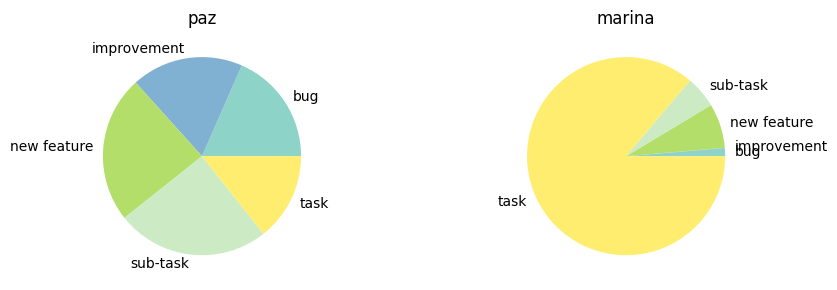

In [20]:
users = top_bottom.loc['heterogeneity', ['top_user', 'bottom_user']].values
types_cols = [x for x in users_calc.columns if x[:5] == 'type_' and x[-5:] == '_time']
data = users_calc.loc[users, types_cols].T
data = data.rename({x: x.replace('type_', '').replace('_time', '') for x in data.index})
f = plt.figure(figsize=(10, 3))
for i, user in enumerate(users):
    ax = f.add_subplot(1, 2, i + 1)
    data[user].plot.pie(cmap=cmap, label='')
    plt.title(user)
plt.tight_layout()

plt.savefig(images_folder + 'metrics_example_heterogeneity')

#### complexity

In [21]:
users_calc['bug_time'].sum() / users_calc['#hours'].sum()

0.13735005941440656

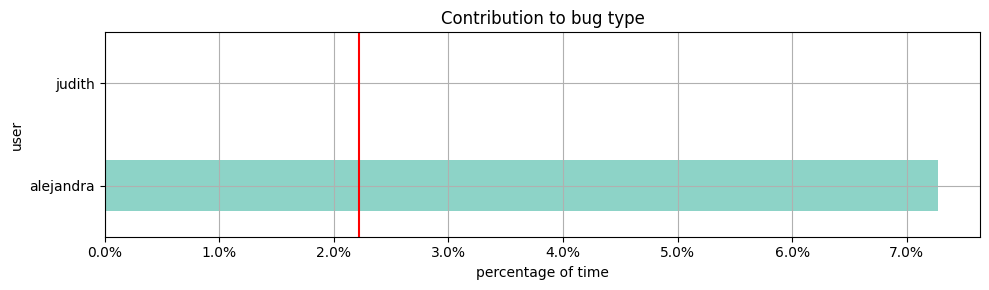

In [22]:
users = top_bottom.loc['complexity', ['top_user', 'bottom_user']].values
ax = metrics['complexity'].loc[users].plot.barh(figsize=(10, 3), cmap=cmap, grid=True, title='Contribution to bug type');
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axvline(1 / users_calc.shape[0], color='red')
ax.set_xlabel('percentage of time')
plt.tight_layout()
plt.savefig(images_folder + 'metrics_example_complexity')

#### collaboration & participation

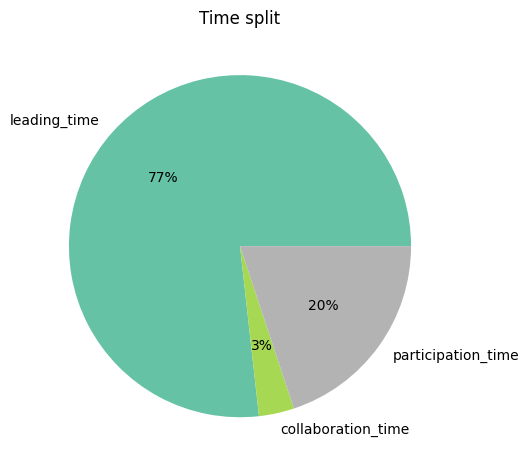

In [23]:
to_plot = users_calc[['leading_time', 'collaboration_time', 'participation_time']].sum()
to_plot.plot.pie(cmap='Set2', label='', autopct='%1.0f%%');
plt.title('Time split')
plt.tight_layout()
plt.savefig(images_folder + 'metrics_example_time_split')

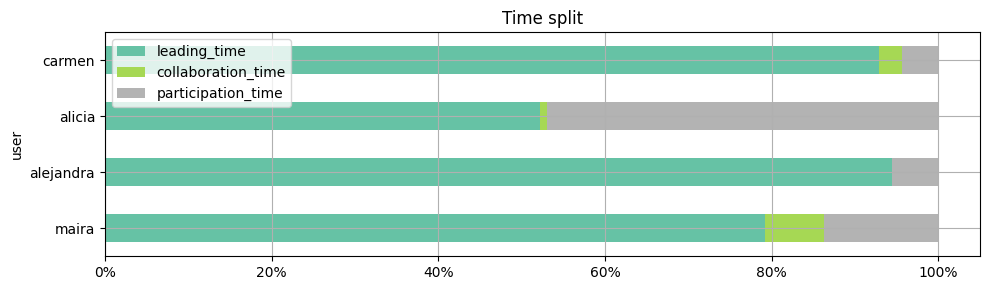

In [24]:
data = users_calc[['leading_time', 'collaboration_time', 'participation_time']]
data = (data.T / data.sum(axis=1)).T
users = list(top_bottom.loc['collaboration', ['top_user', 'bottom_user']].values)
users += list(top_bottom.loc['participation', ['top_user', 'bottom_user']].values)
ax = data.loc[users].plot.barh(stacked=True, figsize=(10, 3), cmap='Set2', grid=True, title='Time split');
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.tight_layout()
plt.savefig(images_folder + 'metrics_example_collaboration')

#### sociability

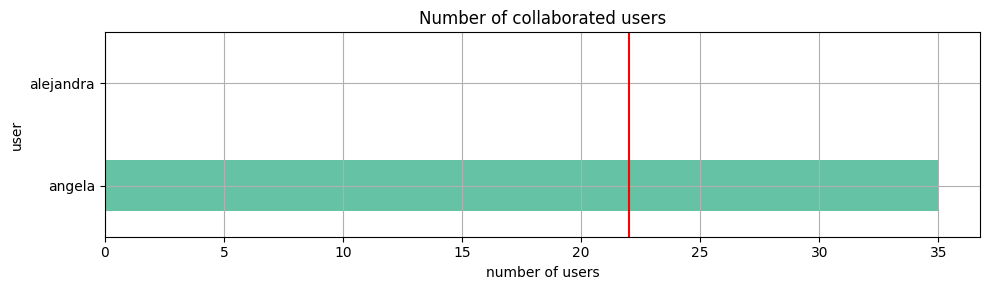

In [25]:
users = top_bottom.loc['sociability', ['top_user', 'bottom_user']].values
data = users_calc['#helped_users'].loc[users]
ax = data.loc[users].plot.barh(figsize=(10, 3), cmap='Set2', grid=True, title='Number of collaborated users');
ax.axvline( (users_calc.shape[0] - 1) // 2, color='red')
ax.set_xlabel('number of users')
plt.tight_layout()
plt.savefig(images_folder + 'metrics_example_sociability')

#### connection

In [26]:
users_calc['meeting_time'].sum() / users_calc['#hours'].sum()

0.036367473750520386

In [27]:
pd.Series(list(set(worklogs_calc[worklogs_calc['issue_is_meeting']]['issue_summary'].values))).sample(5).values

array(['vdb meeting', 'internal meeting for server situation',
       'aed meeting ',
       'meeting about montitor product - integration with exchange-platform',
       '[apr22] - server - web daily meeting'], dtype=object)

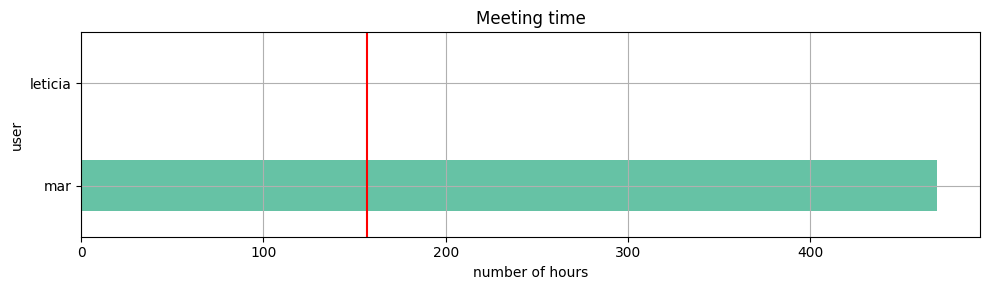

In [28]:
users = top_bottom.loc['connection', ['top_user', 'bottom_user']].values
ax = users_calc['meeting_time'].loc[users].plot.barh(figsize=(10, 3), cmap='Set2', grid=True, title='Meeting time');
ax.axvline( users_calc['meeting_time'].sum() / users_calc.shape[0], color='red')
ax.set_xlabel('number of hours')
plt.tight_layout()
plt.savefig(images_folder + 'metrics_example_connection')

#### management

In [29]:
users_calc['managing_time'].sum() / users_calc['#hours'].sum()

0.03052264251577364

In [30]:
pd.Series(list(set(worklogs_calc[worklogs_calc['issue_is_management']]['issue_summary'].values))).sample(5).values

array(['siena address service. receive as param organization/suborganization',
       '.net team interviews',
       'organization: add new field: or_organization.withoutcostcredit',
       'constraints for vacc_automaticcostcredit creation',
       'test team - interviews'], dtype=object)

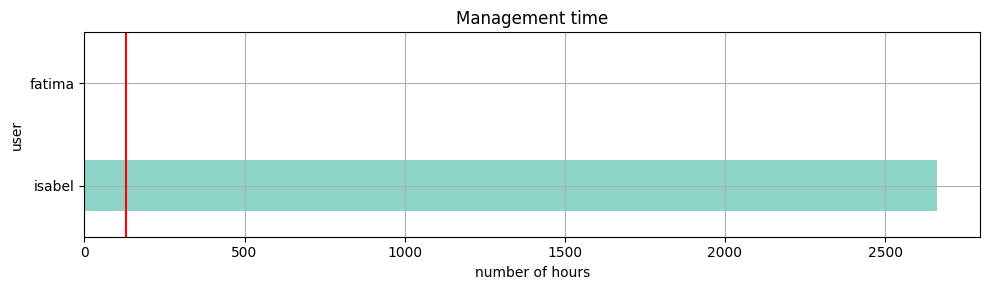

In [31]:
users = top_bottom.loc['management', ['top_user', 'bottom_user']].values
to_plot = users_calc['managing_time'].loc[users]
ax = to_plot.plot.barh(figsize=(10, 3), cmap=cmap, grid=True, title='Management time');
ax.axvline( users_calc['managing_time'].sum() / users_calc.shape[0], color='red')
ax.set_xlabel('number of hours')
plt.tight_layout()
plt.savefig(images_folder + 'metrics_example_management')

#### guidance

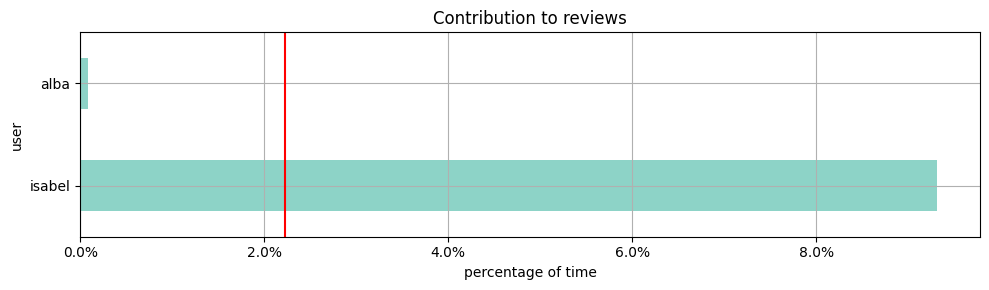

In [32]:
users = top_bottom.loc['guidance', ['top_user', 'bottom_user']].values
to_plot = metrics['guidance'].loc[users]
ax = to_plot.plot.barh(figsize=(10, 3), cmap=cmap, grid=True, title='Contribution to reviews');
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axvline(1 / users_calc.shape[0], color='red')
ax.set_xlabel('percentage of time')
plt.tight_layout()
plt.savefig(images_folder + 'metrics_example_guidance')

#### responsibility

In [33]:
users_interval = [worklogs_calc[(worklogs_calc['date'] >= users_calc.loc[user, 'min_date']) & 
                            (worklogs_calc['date'] <= users_calc.loc[user, 'max_date'])].index 
                  for user in users_calc.index]    
# users by project
users_by_project = pd.pivot_table(worklogs_calc, 
                                  values='#hours', 
                                  index=['user'], 
                                  columns=['issue_project'], 
                                  aggfunc=np.sum)
users_by_project = users_by_project.fillna(0)
# dedication to projects std (in user interval)    
projects_interval = [list(set(worklogs_calc.loc[x]['issue_project'].values)) 
                     for x in users_interval]
# shared by project (in user interval)
dates_interval = [list(set(worklogs_calc.loc[x, 'date'])) for x in users_interval] 
dates_by_project = pd.pivot_table(worklogs_calc, 
                                  values='#hours', 
                                  index=['date'], 
                                  columns=['issue_project'], 
                                  aggfunc=np.sum)
project_contribution =  {user: users_by_project.loc[user] / dates_by_project.loc[dates].sum()
                         for user, dates in zip(users_calc.index, dates_interval)}    
data = pd.DataFrame(project_contribution)

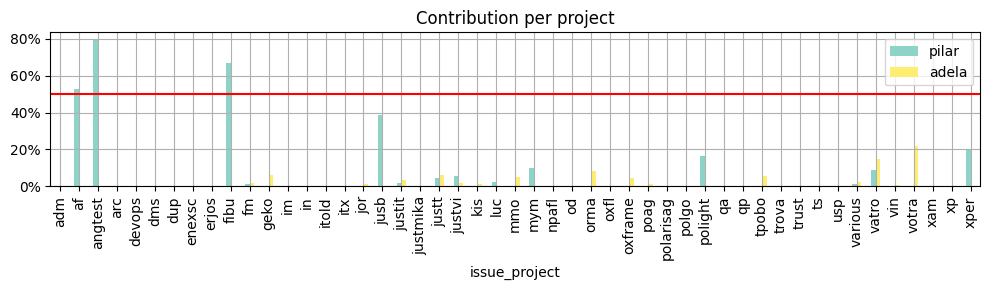

In [34]:
users = top_bottom.loc['responsibility', ['top_user', 'bottom_user']].values
data = data[users].dropna(how='all')
ax = data.plot.bar(figsize=(10, 3), grid=True, title='Contribution per project', cmap=cmap)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(0.5, color='red')
plt.tight_layout()
plt.savefig(images_folder + 'metrics_example_responsability')

# Units

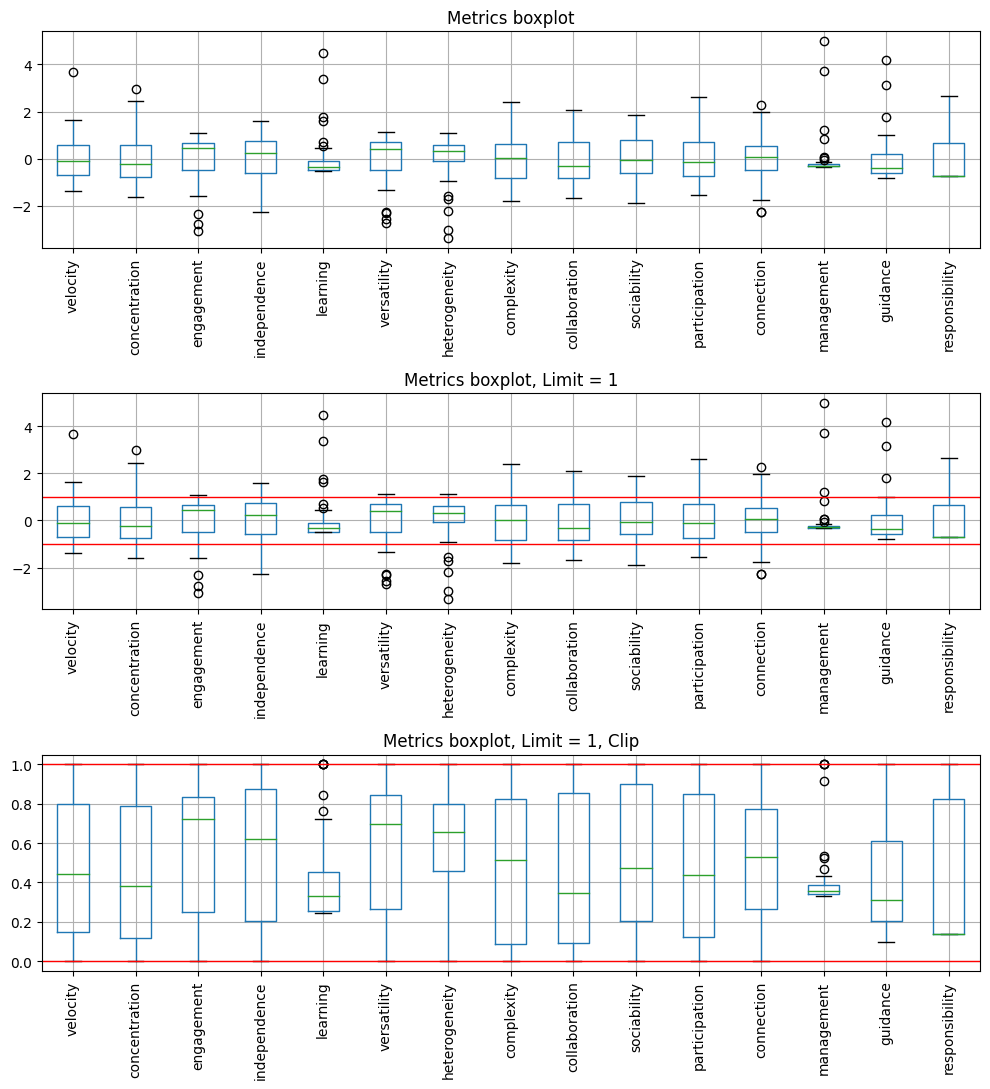

In [35]:
f = plt.figure(figsize=(10, 11))
ax = f.add_subplot(3, 1, 1)
metrics_std = (metrics - metrics.mean()) / metrics.std()
metrics_std.boxplot(rot=90, ax=ax);
plt.title('Metrics boxplot');
ax = f.add_subplot(3, 1, 2)
metrics_std.boxplot(rot=90, ax=ax);
plt.title('Metrics boxplot, Limit = 1');
plt.axhline(1, color='red', linewidth=1);
plt.axhline(-1, color='red', linewidth=1);
ax = f.add_subplot(3, 1, 3)
limit = 1
metrics_std = metrics_std.clip(-limit, limit) 
metrics_std = (metrics_std + limit) / (2 * limit)
metrics_std.boxplot(rot=90, ax=ax);
plt.title('Metrics boxplot, Limit = 1, Clip');
plt.axhline(1, color='red', linewidth=1);
plt.axhline(0, color='red', linewidth=1);
plt.tight_layout()
plt.savefig(images_folder + 'metrics_boxplot')

# Redundancy

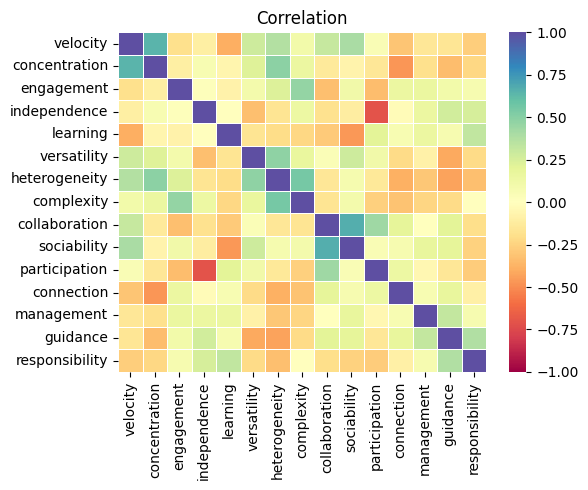

In [36]:
fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1)
corr = metrics_std.corr()
sns.heatmap(corr, cmap="Spectral", vmin=-1, vmax=1, annot=False, linewidths=.5, ax=ax);
plt.title('Correlation');
plt.tight_layout()
plt.savefig(images_folder + 'metrics_correlation')

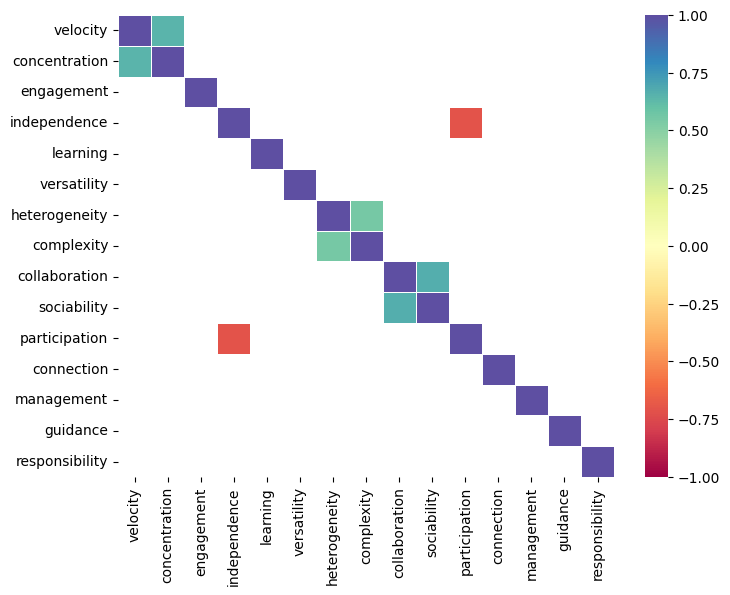

In [37]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)
corr[corr.abs() < 0.5] = float('nan')
sns.heatmap(corr, cmap="Spectral", vmin=-1, vmax=1, annot=False, linewidths=.5, ax=ax);

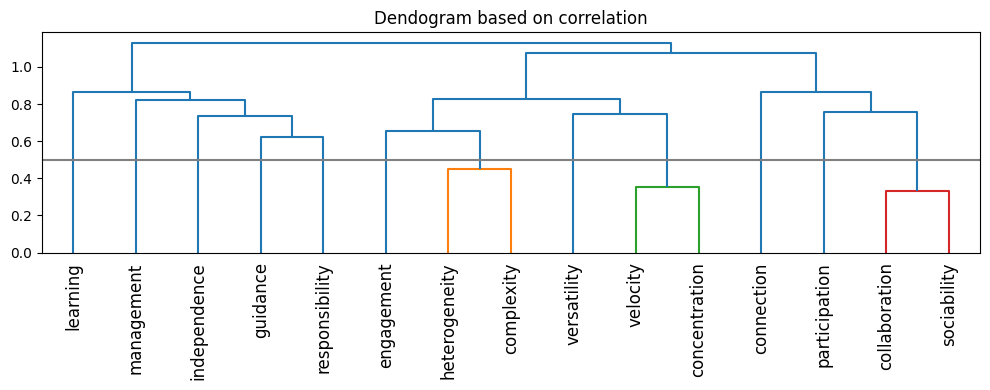

In [38]:
fig = plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 1, 1)
clusters = linkage(metrics_std.T, method = 'average', metric='correlation')
dendrogram(clusters, labels = metrics.columns, leaf_rotation=90, color_threshold=0.5, ax=ax);
plt.title('Dendogram based on correlation')
plt.axhline(0.5, color='grey');
plt.tight_layout()
plt.savefig(images_folder + 'metrics_dendogram')

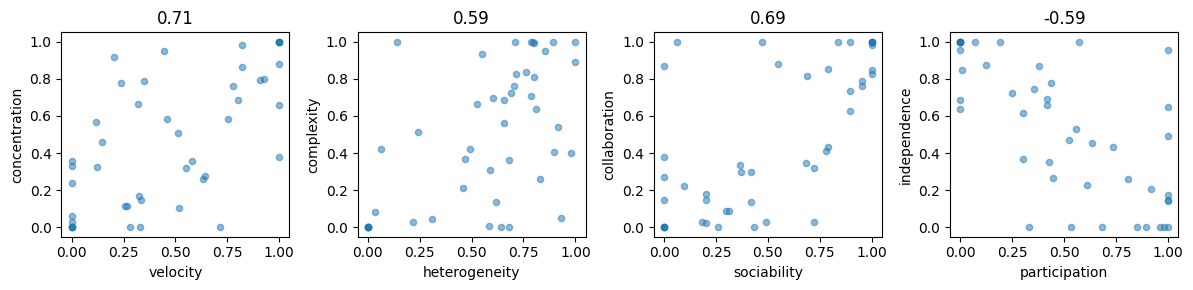

In [39]:
pairs = [
    ['velocity', 'concentration'],
    ['heterogeneity', 'complexity'], 
    ['sociability', 'collaboration'], 
    ['participation', 'independence'],
]

f = plt.figure(figsize=(12, 3))
for i, pair in enumerate(pairs):
    ax = f.add_subplot(1, 4, i + 1)
    metrics_std.plot.scatter(x=pair[0], y=pair[1], alpha=0.5, ax=ax, title=metrics[pair].corr().round(2).iloc[0, 1]);
plt.tight_layout()

# Bias

In [40]:
cols = ['min_date', 'max_date', 'duration', '#daily_hours']
test = users_calc[cols].join(metrics_std)
test[['min_date', 'max_date']] = test[['min_date', 'max_date']].rank(pct=True)

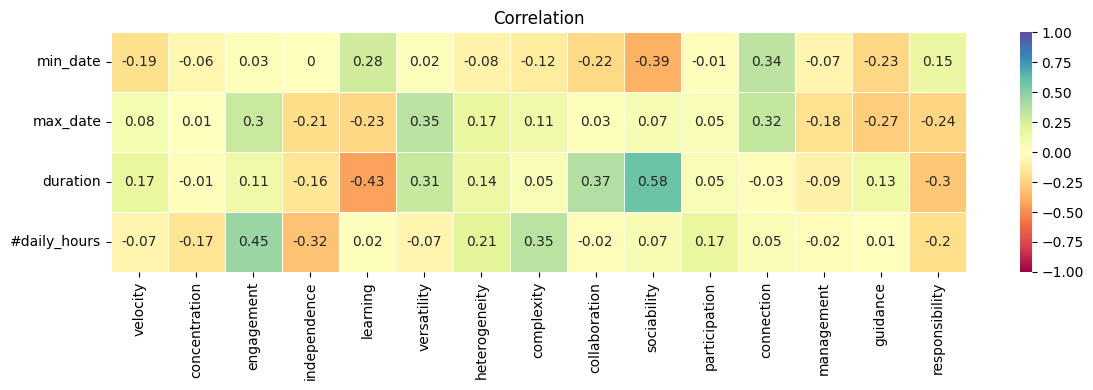

In [41]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 1, 1)
to_plot = test.corr().loc[cols, metrics_std.columns].round(2)
sns.heatmap(to_plot, cmap="Spectral", vmin=-1, vmax=1, annot=True, linewidths=.5, ax=ax);
plt.title('Correlation');
plt.yticks(rotation=0);
plt.tight_layout()
plt.savefig(images_folder + 'metrics_bias')

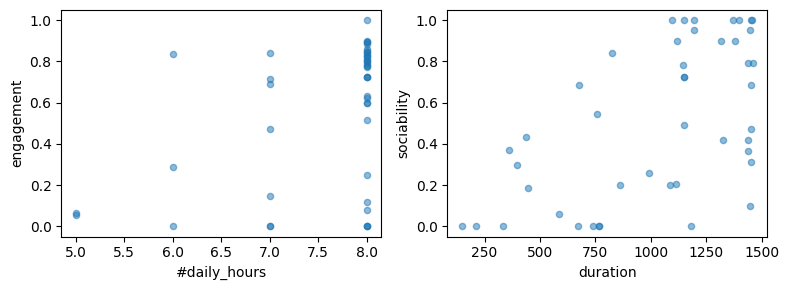

In [42]:
pairs = [
    ['#daily_hours', 'engagement'],
    ['duration', 'sociability'], 
]

f = plt.figure(figsize=(8, 3))
for i, pair in enumerate(pairs):
    ax = f.add_subplot(1, 2, i + 1)
    test.plot.scatter(x=pair[0], y=pair[1], alpha=0.5, ax=ax);
plt.tight_layout()

In [43]:
idx = users_calc[users_calc['#daily_hours'] == 5].index
metrics.loc[idx, 'engagement']

user
maira    0.622209
rocio    0.619185
Name: engagement, dtype: float64

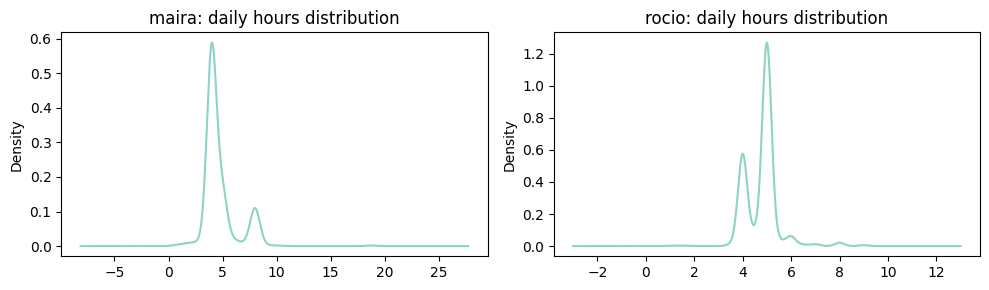

In [44]:
f = plt.figure(figsize=(10, 3))
for i, user in enumerate(idx):
    ax = f.add_subplot(1, 2, i + 1)
    to_plot = worklogs_calc[worklogs_calc['user'] == user].groupby('date').sum()['#hours']
    to_plot.plot.kde(ax=ax, title=user + ': daily hours distribution', cmap=cmap)
plt.tight_layout()
plt.savefig(images_folder + 'metrics_bias_daily_hours')